In [60]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme()
sns.set_style("dark")

## Load extracted features

In [61]:
data_basepath = './n96ncsr5g4-1'
url_features_path = './url_features.json'
html_features_path = './html_features.json'

In [62]:
with open(url_features_path) as f:
    url_features = json.load(f)
    
with open(html_features_path) as f:
    html_features = json.load(f)

In [63]:
features = {}
for k in url_features.keys():
    url_feat = url_features[k]
    html_feat = html_features[k]
    
    url_feat.update(html_feat)
    features[k] = url_feat

In [64]:
df = pd.DataFrame.from_dict(features, orient='index')
df.head()

,label,url_length,num_subdomains,uses_https,contains_ip,contains_phishing_keywords,contains_at_symbol,url_depth,is_shortened_url,is_punycode,...,login_form_present,javascript_redirects_present,iframes_count,num_obfuscated_scripts,external_js_inclusion,num_inline_styles,num_script_tags,num_iframe_tags,num_img_tags,num_a_tags
1,1,34,2,False,False,False,False,3,False,False,...,False,False,0,0,False,8,1,0,4,1
2,0,40,3,True,False,False,False,2,False,False,...,False,False,0,0,False,4,4,0,2,7
3,0,48,3,True,False,False,False,3,False,False,...,False,False,0,0,True,3,8,0,5,77
4,0,52,3,True,False,False,False,4,False,False,...,False,False,1,0,False,10,6,1,19,150
5,0,33,4,True,False,False,False,2,False,False,...,False,False,1,1,True,5,17,1,12,58


## Check for missing values

In [65]:
df.isnull().sum()

label                           0
url_length                      0
num_subdomains                  0
uses_https                      0
contains_ip                     0
contains_phishing_keywords      0
contains_at_symbol              0
url_depth                       0
is_shortened_url                0
is_punycode                     0
has_redirection                 0
is_domain_valid                 0
days_until_expiration           0
registration_length             0
num_forms                       0
num_username_fields             0
num_password_fields             0
num_hidden_fields               0
form_action                     0
form_autocomplete               0
external_links_count            0
login_form_present              0
javascript_redirects_present    0
iframes_count                   0
num_obfuscated_scripts          0
external_js_inclusion           0
num_inline_styles               0
num_script_tags                 0
num_iframe_tags                 0
num_img_tags  

## Convert categorical features to one-hot

In [66]:
dummy_feats = pd.get_dummies(df['form_action'], drop_first=True, prefix='form_action')
df = pd.concat([df.drop('form_action', axis=1), dummy_feats], axis=1)
df.head()

,label,url_length,num_subdomains,uses_https,contains_ip,contains_phishing_keywords,contains_at_symbol,url_depth,is_shortened_url,is_punycode,...,num_obfuscated_scripts,external_js_inclusion,num_inline_styles,num_script_tags,num_iframe_tags,num_img_tags,num_a_tags,form_action_1,form_action_2,form_action_3
1,1,34,2,False,False,False,False,3,False,False,...,0,False,8,1,0,4,1,0,0,1
2,0,40,3,True,False,False,False,2,False,False,...,0,False,4,4,0,2,7,0,1,0
3,0,48,3,True,False,False,False,3,False,False,...,0,True,3,8,0,5,77,1,0,0
4,0,52,3,True,False,False,False,4,False,False,...,0,False,10,6,1,19,150,0,1,0
5,0,33,4,True,False,False,False,2,False,False,...,1,True,5,17,1,12,58,0,0,1


## Split into training and test set

In [67]:
from sklearn.model_selection import train_test_split

X = df.drop('label', axis=1).to_numpy().astype(float)
y = df['label'].to_numpy()

test_size = 0.2
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print(f'Number of training samples: {X_train.shape}')
print(f'Number of test samples: {X_test.shape}')

Number of training samples: (64000, 32)
Number of test samples: (16000, 32)


## Normalize continuous features and performa PCA analysis

In [68]:
def plot_pca(X_pca, y, n_components):
    X_list = [X_pca[:, i] for i in range(n_components)]
    
    if len(X_list) == 3:
        ax = plt.axes(projection='3d')
    else:
        ax = plt.axes() 
    ax.scatter(*X_list, c=y, cmap='RdYlBu')
    ax.set_title(f'Distribution of data using PCA with {n_components = }')
    plt.show()
    plt.close()

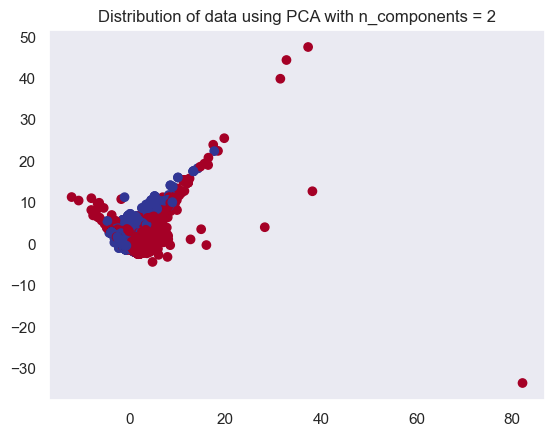

In [69]:
from sklearn.decomposition import PCA

cont_feats = {
    "url_length",
    "url_depth",
    "days_until_expiration",
    "registration_length",
    "num_forms",
    "num_username_fields",
    "num_password_fields",
    "num_hidden_fields",
    "form_autocomplete",
    "external_links_count",
    "iframes_count",
    "num_obfuscated_scripts",
    "num_inline_styles",
    "num_script_tags",
    "num_iframe_tags",
    "num_img_tags",
    "num_a_tags",
  }
columns = df.columns[1:]
cont_ids = [i for i, c in enumerate(columns) if c in cont_feats]


mean = X_train[:, cont_ids].mean(axis=0, keepdims=True)
std = X_train[:, cont_ids].std(axis=0, keepdims=True)
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
X_train_norm[:, cont_ids] = (X_train[:, cont_ids] - mean) / std
X_test_norm[:, cont_ids] = (X_test[:, cont_ids] - mean) / std

pca = PCA()
pca.fit(X_train_norm)
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)
        
plot_pca(X_train_pca, y_train, n_components=2)

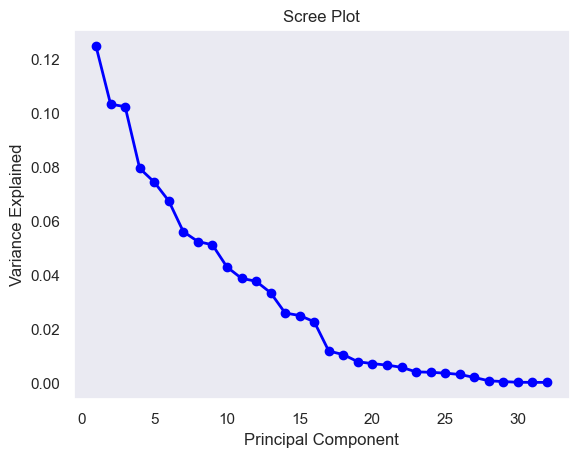

In [70]:
x_ticks = np.arange(pca.n_components_) + 1
plt.plot(x_ticks, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [71]:
from sklearn import metrics

def compute_model_metrics(model, X, y_true):
    y_pred = model.predict(X)
    
    print("Confusion Matrix")
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(2, 2))
    ax = sns.heatmap(confusion_matrix, cmap="crest",  annot=True, fmt="d", linewidths=.1)
    xticks = [i + 0.5 for i in range(2)]
    ax.set_xticks(
        xticks, ['legitimate', 'phishing'], rotation=45, ha='right'
    )
    ax.set_yticks(
        xticks, ['legitimate', 'phishing'], rotation=0, va='top'
    )
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    plt.show()

    report = metrics.classification_report(
        y_true, y_pred, target_names=['legitimate', 'phishing'], digits=4
    )
    print(report)
    test_acc = metrics.accuracy_score(y_true, y_pred)
    print(f'Accuracy: {test_acc:.4f}')
    
    test_precision = metrics.precision_score(y_true, y_pred, average='micro')
    print(f'Micro Precision: {test_precision:.4f}')
        
    test_recall = metrics.recall_score(y_true, y_pred, average='micro')
    print(f'Micro Recall/TPR: {test_recall:.4f}')
    
    test_f1 = metrics.f1_score(y_true, y_pred, average='micro')
    print(f'Micro f1-score: {test_f1:.4f}')

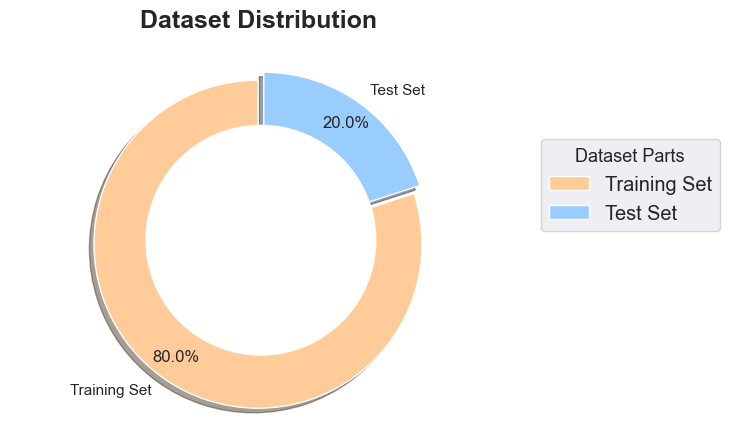

In [72]:
import matplotlib.pyplot as plt

# Sizes for each dataset part
train_size = X_train.shape[0]
test_size = X_test.shape[0]

# Labels for the pie chart sectors
labels = ['Training Set', 'Test Set']

# Colors for each sector
colors = ['#ffcc99', '#99ccff']  # Light orange for training, light blue for test

# Explode out each slice a little
explode = (0.03, 0.03)

# Create the figure and axis
fig1, ax1 = plt.subplots()

# Create the pie chart with the above data and format the look
ax1.pie([train_size, test_size], labels=labels, autopct='%1.1f%%', startangle=90,
        colors=colors, explode=explode, shadow=True, pctdistance=0.85)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')  

# Fancy up the title and set the font
plt.title('Dataset Distribution', pad=20, fontdict={'fontsize': 18, 'fontweight': 'bold'})

# Add a legend with a fancy box
plt.legend(frameon=True, bbox_to_anchor=(1.05, 0.8), loc='upper left', fontsize='large', title='Dataset Parts', title_fontsize='13')

# Show the plot
plt.show()


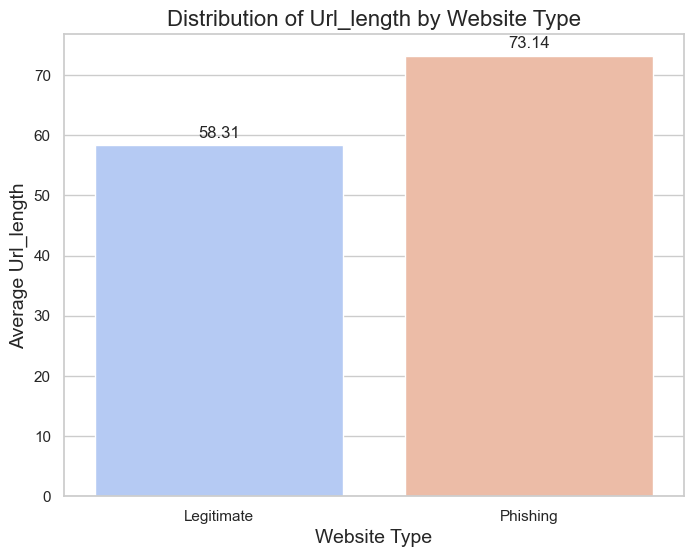

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Updated function to plot the feature distribution without error bars
def plot_feature_distribution(df, feature_name):
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(8, 6))

    # Create the barplot without error bars
    ax = sns.barplot(x='label', y=feature_name, data=df, palette='coolwarm', ci=None)

    # Add annotations on each bar to show the mean value
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

    # Improve the labeling
    plt.title(f'Distribution of {feature_name.capitalize()} by Website Type', fontsize=16)
    plt.xlabel('Website Type', fontsize=14)
    plt.ylabel(f'Average {feature_name.capitalize()}', fontsize=14)
    plt.xticks([0, 1], ['Legitimate', 'Phishing'])  # Assuming binary labels: 0 and 1

    # Show the plot
    plt.show()

# Example usage with the feature 'url_length'
plot_feature_distribution(df, 'url_length')


<Figure size 500x500 with 0 Axes>

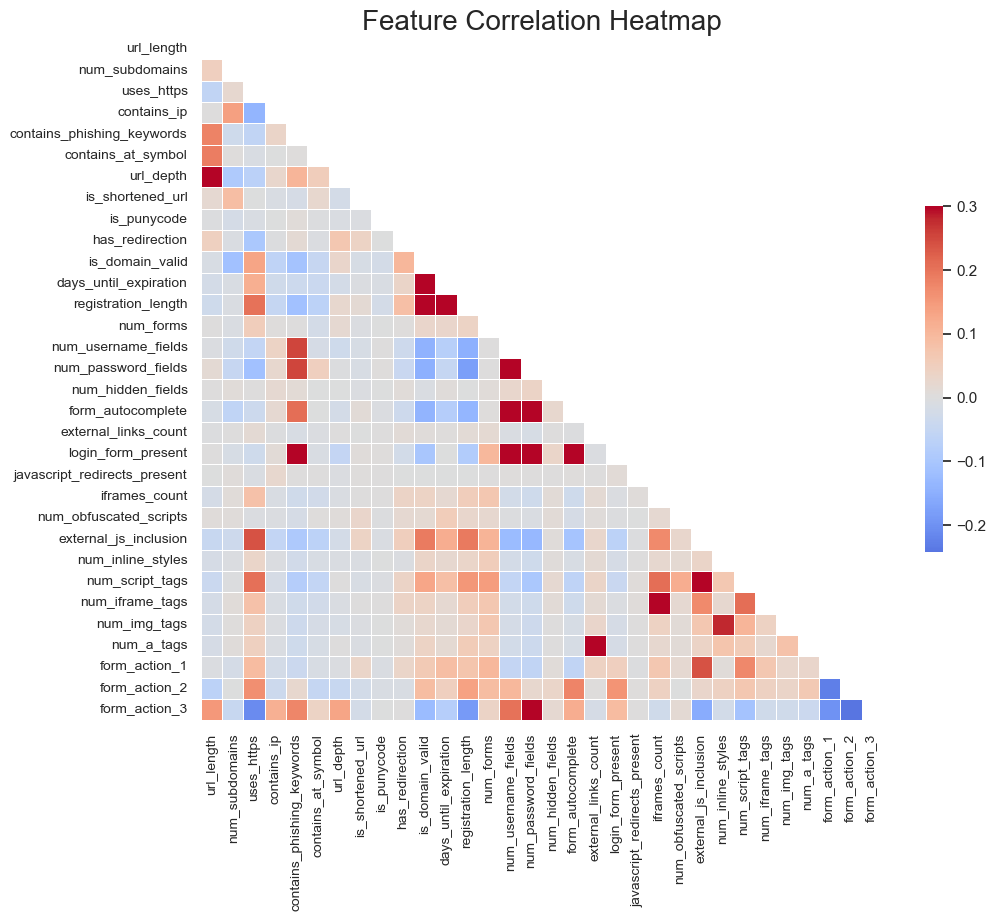

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame after preprocessing but before dropping the 'label'
correlation_matrix = df.drop('label', axis=1).corr()

# Increase the size of the heatmap to make it more readable
plt.figure(figsize=(5, 5))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

# We're not annotating each cell with the correlation coefficient for readability
# If you want to add annotations for significant correlations, you can do so selectively:
# threshold = 0.8 # example threshold
# annot = np.where(np.abs(correlation_matrix) >= threshold, correlation_matrix.values, np.full(correlation_matrix.shape, ""))

# Apply the annotations
# sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=annot, fmt='s', cbar=False)

plt.title('Feature Correlation Heatmap', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


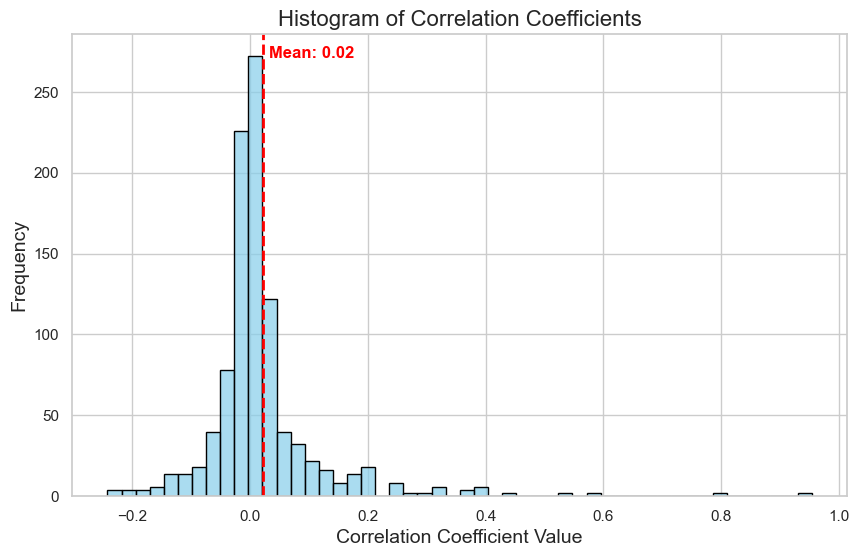

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the correlation matrix and filter out self-correlations (1.0)
corr_values = correlation_matrix.values.flatten()
corr_values = corr_values[corr_values != 1]

# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(corr_values, bins=50, color='skyblue', alpha=0.7, edgecolor='black')

# Add a vertical line for the mean correlation
mean_corr = np.mean(corr_values)
plt.axvline(mean_corr, color='red', linestyle='dashed', linewidth=2)

# Annotate the mean line
plt.text(mean_corr+0.01, plt.ylim()[1]*0.95, 'Mean: {:.2f}'.format(mean_corr),
         color='red', fontweight='bold')

# Improve the labeling
plt.title('Histogram of Correlation Coefficients', fontsize=16)
plt.xlabel('Correlation Coefficient Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot with improvements
plt.show()
